# The Copernicus Climate Change Service
[ERA5 hourly data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels).

In [1]:
import xarray as xr
import pandas as pd
import cdsapi
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.8.2
pandas version: 1.0.2
xarray version: 0.14.0


In [2]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature', 'sea_surface_temperature',
        ],
        'year': '2020',
        'month': [
            '09', '10',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            47.12, 6.57, 36.4,
            18.52,
        ],
        'format': 'netcdf',
    },
    'download.nc')

2020-10-15 23:03:12,980 INFO Welcome to the CDS
2020-10-15 23:03:12,981 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-15 23:03:13,189 INFO Request is queued
2020-10-15 23:03:14,237 INFO Request is running
2020-10-15 23:04:02,808 INFO Request is completed
2020-10-15 23:04:02,811 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1602795792.7974255-20830-17-bc908c97-eafc-47c2-8dca-2c64a287426a.nc to download.nc (2.6M)
2020-10-15 23:04:04,457 INFO Download rate 1.6M/s   


Result(content_length=2710952,content_type=application/x-netcdf,location=http://136.156.132.236/cache-compute-0007/cache/data4/adaptor.mars.internal-1602795792.7974255-20830-17-bc908c97-eafc-47c2-8dca-2c64a287426a.nc)

In [2]:
era5_xr = xr.open_dataset('download.nc')
era5_xr

<xarray.Dataset>
Dimensions:    (latitude: 43, longitude: 48, time: 328)
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-11T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-15 21:03:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [3]:
lats = era5_xr['latitude']
print("Min. Latitude: {0:.2f}, Max. Latitude: {1:.2f}".format(lats.data.min(), lats.data.max()))

Min. Latitude: 36.40, Max. Latitude: 46.90


In [4]:
lons = era5_xr['longitude']
print("Min. Longitude: {0:.2f}, Max. Longitude: {1:.2f}".format(lons.data.min(), lons.data.max()))

Min. Longitude: 6.57, Max. Longitude: 18.32


In [5]:
time = era5_xr['time']
time.shape

(328,)

In [6]:
temperature2m = era5_xr['t2m']
temperature2m

<xarray.DataArray 't2m' (time: 328, latitude: 43, longitude: 48)>
[676992 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-11T21:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [7]:
sea_temperature = era5_xr['sst']
sea_temperature

<xarray.DataArray 'sst' (time: 328, latitude: 43, longitude: 48)>
[676992 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.57 6.82 7.07 7.32 ... 17.82 18.07 18.32
  * latitude   (latitude) float32 46.9 46.65 46.4 46.15 ... 36.9 36.65 36.4
  * time       (time) datetime64[ns] 2020-09-01 ... 2020-10-11T21:00:00
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [8]:
era5_xr.close()

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import numpy as np

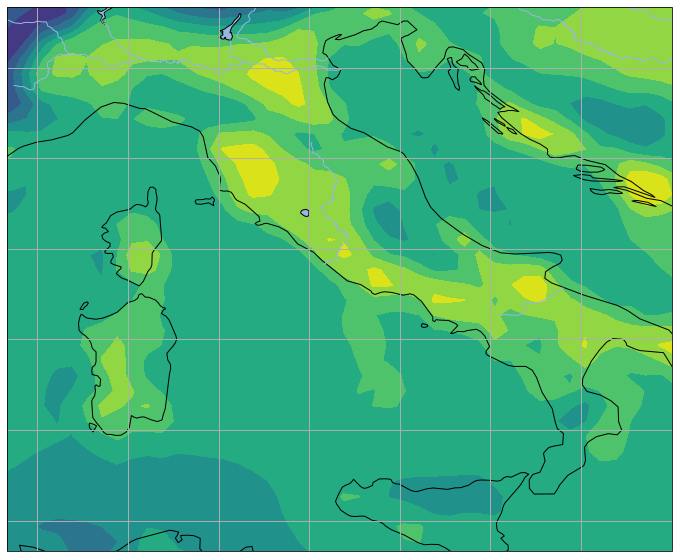

In [17]:
import cartopy.crs as ccrs
import cartopy
plt.figure(figsize=(20, 10))
central_lon, central_lat = 12, 41
extent = [7, 18, 37, 46]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.gridlines()
ax.contourf(lons, lats, temperature2m[100])
#ax.contourf(lons, lats, sea_temperature[100])

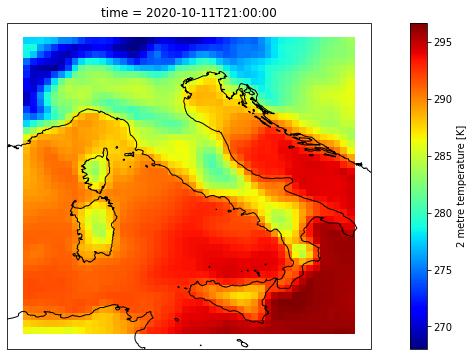

In [18]:
plt.figure(figsize=(14,6))
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
temperature2m[327].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')

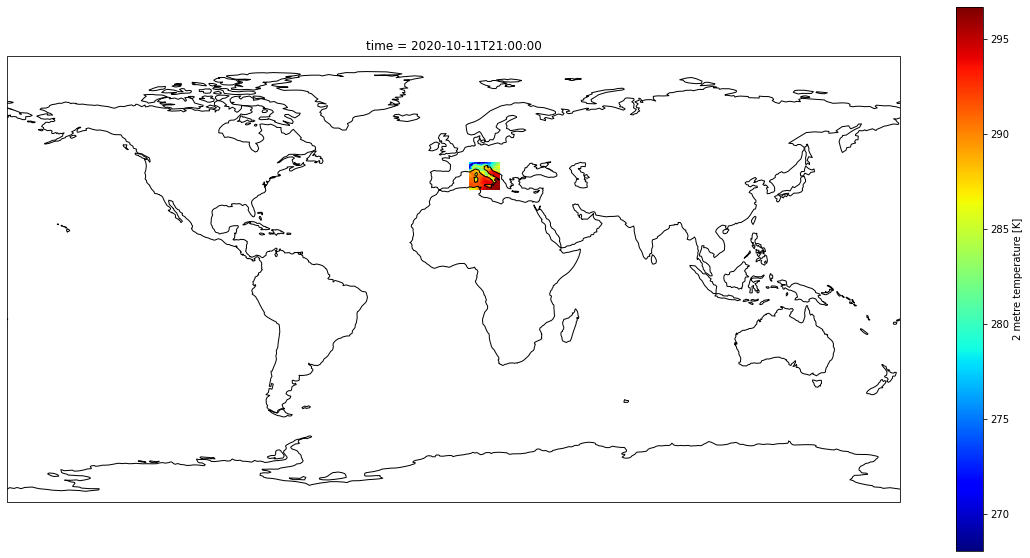

In [19]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global() 
ax.coastlines()
temperature2m[327].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')

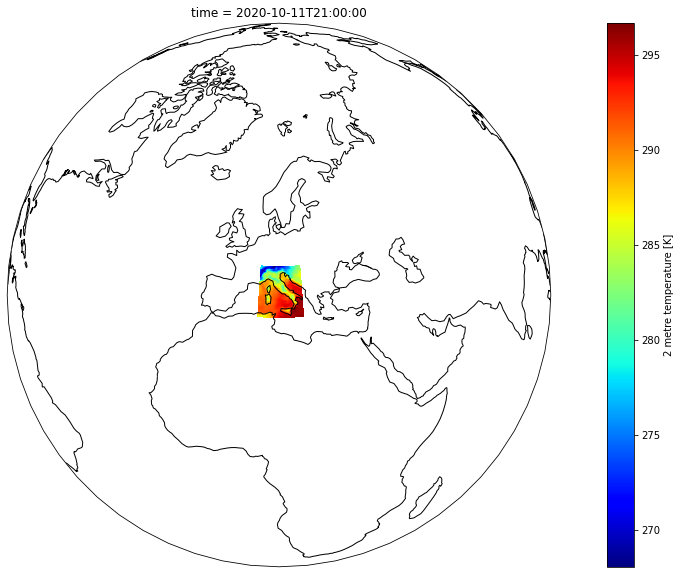

In [25]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=12, central_latitude=41))
ax.coastlines()
ax.set_global()
temperature2m[327].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet', transform=ccrs.PlateCarree())

## References
[Hersbach et al. - The ERA5 global reanalysis](https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.3803)